In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
# inspector.get_columns(Measurement)
columns = inspector.get_columns('measurement')

In [11]:
def ColumnInfo (table_name):
    '''Takes the name of a column and usus SQLAlchemy to print its column names and types. '''
    columns = inspector.get_columns(table_name)
    
    for c in columns:
        print(c['name'], c['type'])

In [12]:
# Print column info
ColumnInfo('measurement')
print('----------------')
ColumnInfo('station')

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [100]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the latest date
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert last date from str to datetime
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')
print(lastDate)

# Calculate the date 1 year ago from the last data point in the database
year_ago = (lastDate - dt.timedelta(days=365))
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_lastYear = session.query(Measurement.date, Measurement.prcp).\
                    filter(func.strftime('%Y-%m-%d', Measurement.date) >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_lastYear)
prcp_df.head()

2017-08-23 00:00:00
2016-08-23 00:00:00


,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [16]:
# Sort the dataframe by date
prcp_sorted = prcp_df.sort_values(by=['date'], ascending=True)

# Rename Columns
prcp_sorted = prcp_sorted.rename(columns={'date':'date'.title(), 'prcp':'precipitation'.title()})

# Drop NaN columns
prcp_sorted = prcp_sorted.dropna()
prcp_sorted.head()

,Date,Precipitation
0,2016-08-24,0.08
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45


Text(0, 0.5, 'Precipitation')

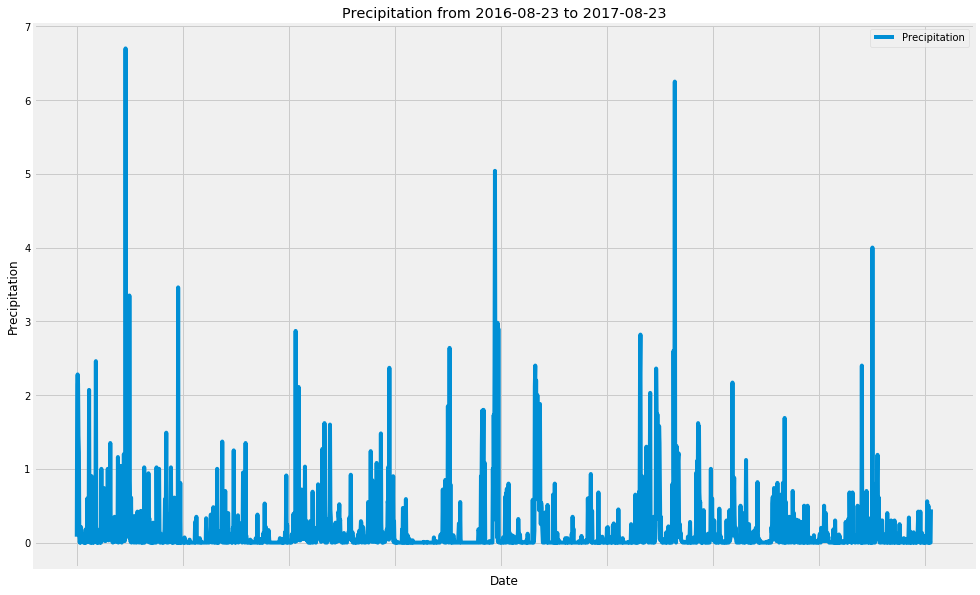

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

# Make graph pretty later
prcp_sorted.plot(x='Date', y= 'Precipitation', figsize=(15,10))
plt.title(label=f'Precipitation from {year_ago.strftime("%Y-%m-%d")} to {lastDate.strftime("%Y-%m-%d")}')
plt.ylabel('Precipitation')

In [18]:
# Summary Statistics
prcp_sorted.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analyisis

In [21]:
from sqlalchemy import distinct

In [22]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(distinct(Station.id))).scalar()
print(f'There are {station_count} stations in this dataset')

There are 9 stations in this dataset


In [23]:
session.query(Station.id, Station.name, Station.station).all()

[(1, 'WAIKIKI 717.2, HI US', 'USC00519397'),
 (2, 'KANEOHE 838.1, HI US', 'USC00513117'),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830'),
 (4, 'PEARL CITY, HI US', 'USC00517948'),
 (5, 'UPPER WAHIAWA 874.3, HI US', 'USC00518838'),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523'),
 (7, 'WAIHEE 837.5, HI US', 'USC00519281'),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918'),
 (9, 'MANOA LYON ARBO 785.2, HI US', 'USC00516128')]

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Query to get the station name of the statioon with the most entries
max_station = session.query(Measurement.station).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first()[0]
                                                       
print(max_station)

USC00519281


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Query for max temp for station with highest entries
max_temp = session.query(func.max(Measurement.tobs)).\
            filter(Measurement.station == max_station).scalar()

print(max_temp)

85.0


In [27]:
# Query for min temp for the station with the most entries
min_temp = session.query(func.min(Measurement.tobs)).\
            filter(Measurement.station == max_station).scalar()
print(min_temp)

54.0


In [28]:
# Query foor Average temp for the station with the most entries
avg_temp = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == max_station).scalar()

print(avg_temp)

71.66378066378067


In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

lastYear_tobs = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == max_station).\
                    filter(func.strftime('%Y-%m-%d', Measurement.date) >= year_ago).all()

tobs_df = pd.DataFrame(lastYear_tobs)
tobs_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


Text(0, 0.5, 'Frequency')

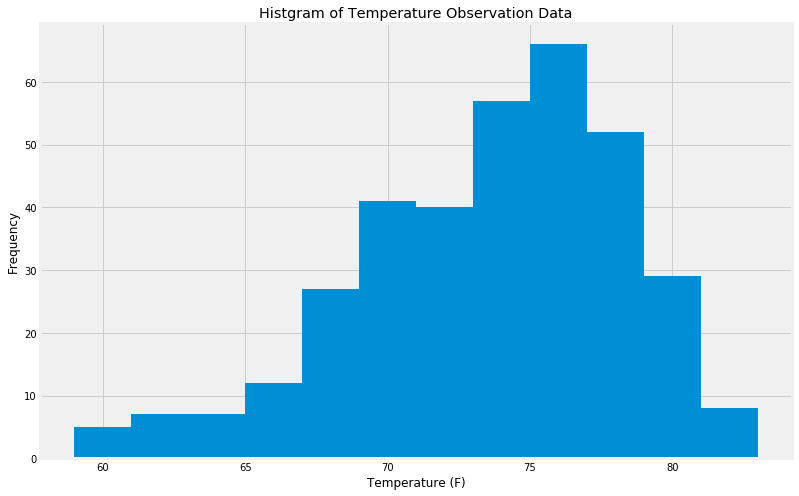

In [51]:
# Plot a histogram of tobs
plt.figure(figsize=(12,8))
plt.hist(tobs_df.tobs, bins=12)
plt.title('Histgram of Temperature Observation Data')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')


### Temperature Analysis (Optional)

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

    ![temperature](Images/temperature.png)

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Print the last available date that we found earlier for reference
print(lastDate)

2017-08-23 00:00:00


In [33]:
# Set trip dates. Since I get to decide, let's say I take my hypothetical vacation on my birthday and go for 9 days
tripStart = dt.datetime.strptime('2019-04-11','%Y-%m-%d')
tripEnd = tripStart + dt.timedelta(days=9)

In [35]:
# Initial check if dates are beyond the last date in the db
date_outside = False
if tripEnd > lastDate:
    date_outside = True

# Set search variables to the trip variables to start.
search_start = tripStart
search_end = tripEnd

# check if those dates are lower than the last date in the db; if not, subtract another year until they are
while date_outside:
    search_start -= dt.timedelta(days=365)
    search_end -= dt.timedelta(days=365)
    
    if search_end <= lastDate:
        date_outside = False

print(search_start, search_end)

2017-04-11 00:00:00 2017-04-20 00:00:00


In [36]:
# Use calc_temps to get the temp data for the search dates

trip_temps = calc_temps(search_start, search_end)[0]

print(trip_temps)

(67.0, 73.37931034482759, 83.0)


[Text(0, 0, '2019-04-11 \n Thru \n 2019-04-20')]

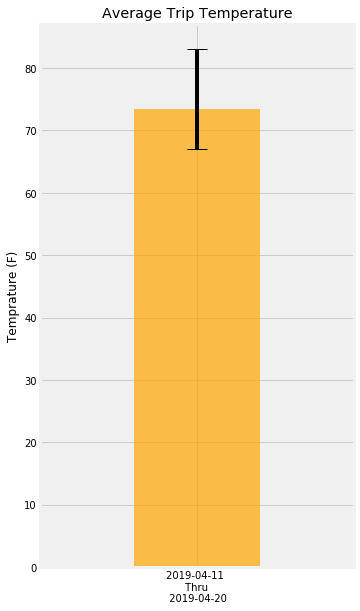

In [37]:
# Plot Barchart of Data
# Define a 2 X 1 matrix holding ther error values. This can amke the error bars asymmetric, in case the mean temp is closer to the max or min.
asm_error = [[trip_temps[1]-trip_temps[0]],
             [trip_temps[2]-trip_temps[1]]]

fig, ax = plt.subplots(figsize=(5,10))
ax.bar(x=1, height=trip_temps[1], yerr=asm_error, capsize=10, color='orange', alpha=0.7)

# Graph formatting
plt.ylabel('Temprature (F)')
ax.set_title('Average Trip Temperature')

# Increase the xlimits so the bar doesn't look really wide
ax.set_xlim(0,2)
ax.set_xticks([1])
ax.set_xticklabels([f"{tripStart.strftime('%Y-%m-%d')} \n Thru \n {tripEnd.strftime('%Y-%m-%d')}"])


## Optional Challenge Assignment

In [38]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# Test data on a small list of three dates
testDates = ['04-11','04-12','04-13']

In [40]:
# list comprehension to fill the test_normals list with temp data for the given dates
test_normals = [daily_normals(date)[0] for date in testDates]

for data in test_normals:
    print(data)

(65.0, 72.49180327868852, 82.0)
(65.0, 72.22413793103448, 80.0)
(64.0, 71.52542372881356, 79.0)


In [41]:
# Get the num of days in the trip as an integer
trip_days = (tripEnd - tripStart).days
print(trip_days)

9


In [42]:
# Use the trip length to generate a list of dates, taking just the month and day

trip_dates = [(tripStart + dt.timedelta(days=i)).strftime('%m-%d') for i in range(trip_days+1)]


for date in trip_dates:
    print(date)

04-11
04-12
04-13
04-14
04-15
04-16
04-17
04-18
04-19
04-20


In [43]:
# Get trip normals data for each date in trip_dates
trip_normals = [daily_normals(date)[0] for date in trip_dates]

for temp_data in trip_normals:
    print(temp_data)

(65.0, 72.49180327868852, 82.0)
(65.0, 72.22413793103448, 80.0)
(64.0, 71.52542372881356, 79.0)
(65.0, 72.75, 81.0)
(61.0, 71.79310344827586, 79.0)
(62.0, 71.55357142857143, 81.0)
(65.0, 71.93103448275862, 77.0)
(67.0, 72.49152542372882, 77.0)
(65.0, 72.42105263157895, 83.0)
(64.0, 72.73684210526316, 80.0)


In [44]:
# Create DF from normals temp data
normals_df = pd.DataFrame(trip_normals, columns=['Min','Avg','Max'])

# Add dates to DF
normals_df['Date'] = trip_dates

# Set index to date
normals_df = normals_df.set_index('Date')

# Print DF for verification
normals_df

,Min,Avg,Max
Date,,,
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0
04-17,65.0,71.931034,77.0
04-18,67.0,72.491525,77.0
04-19,65.0,72.421053,83.0


Text(0.5, 1.0, 'Daily Normals for Planned Vacation')

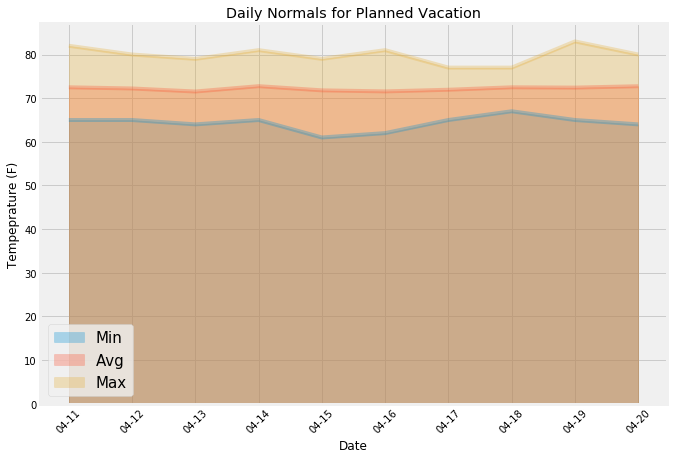

In [45]:
# Create Stacked area plot
ax = normals_df.plot.area(stacked=False, alpha=0.3, figsize=(10,7), xticks=range(len(normals_df)))
ax.set_ylabel('Tempeprature (F)')
ax.legend(loc='best', prop={'size':15})
ax.set_xticklabels(labels=normals_df.index, rotation=45)
ax.set_title(label='Daily Normals for Planned Vacation')